# Projet python L3

In [487]:
import pandas as pd  
import yfinance as yf 
import numpy as np 
import matplotlib.pyplot as plt  

import fonctions
import importlib

In [488]:
importlib.reload(fonctions)

<module 'fonctions' from '/Users/tristan/Desktop/ProjL3/fonctions.py'>

#### **1. Définition des données**

In [489]:
print("Tickers français par défaut: 'AIR', 'OR', 'AI', 'BNP', 'MC', 'SU', 'SAN', 'KER'")
user_input = input("Appuyez sur Entrée pour utiliser les valeurs par défaut ou entrez vos propres tickers que vous voulez optimiser: séparé d'une virgule ")

# Utilise les valeurs par défaut si l'utilisateur appuie simplement sur Entrée
tickers = user_input.strip().upper() if user_input.strip().upper() != "" else "AIR, SU, SAN, EL, TTE, DG, BN"
print("Tickers sélectionnés:", tickers)

date_debut = input("Entrez la date de début (format YYYY-MM-DD, par défaut 2014-01-01) Appuyez sur Entrée pour utiliser les valeurs par défaut : ") or "2014-01-01"

prix = yf.download(tickers,start=date_debut)['Adj Close']  

rendements = prix.pct_change().dropna(axis=1,how='all').iloc[1:].dropna(axis=1)

Tickers français par défaut: 'AIR', 'OR', 'AI', 'BNP', 'MC', 'SU', 'SAN', 'KER'
Tickers sélectionnés: MC.PA, KER.PA, CFR.SW, UHR.SW, DSY.PA, LUX, VEOEY


[*********************100%***********************]  7 of 7 completed
/var/folders/gq/2r9v2_2d44l3h4sqggzhwyd40000gn/T/ipykernel_10267/1507051555.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rendements = prix.pct_change().dropna(axis=1,how='all').iloc[1:].dropna(axis=1)


On demande à l'utilisateur de choisir quel ratio parmi Sharpe, Sortino et Calmar souhaite t-il utiliser et quelle méthode d'optimisation appliquer. Les valeurs par défaut sont 'Sharpe' et optimisation 'courte mais moins efficace'.

In [490]:
choix_ratio = input("Voulez-vous optimiser votre portefeuille selon le ratio de Sharpe, Sortino, ou Calmar? Entrez 'Sharpe', 'Sortino' ou 'Calmar' (par défaut : Sharpe) : ") or "Sharpe"
print(f"Vous avez choisi d'optimiser selon le ratio de {choix_ratio}.")

choix_optimisation = input("Voulez-vous utiliser une méthode d'optimisation longue et très efficace (1) ou courte mais moins efficace (2)? (par défaut : 2 (courte mais moins efficace)) : ") or "2"
print(f"Vous avez choisi d'utiliser une méthode d'optimisation {choix_optimisation}.")

choix_VAD = input("Souhaitez vous intégrer le mécanisme de vente à découvert ? Répondez par 'Oui' ou 'Non' (par défaut: Non)") or 'Non'
if choix_VAD == 'Oui':
    VAD= True
else:
    VAD=False

Vous avez choisi d'optimiser selon le ratio de Sharpe.
Vous avez choisi d'utiliser une méthode d'optimisation 2.


In [491]:
# Demander à l'utilisateur de saisir le taux sans risque, avec 0.3 comme valeur par défaut.
try:
    rendement_taux_sans_risque = float(input("Entrez le rendement du taux sans risque (en %, par défaut 0.3) : ") or 0.3)
except ValueError:
    print("Entrée invalide. Utilisation de la valeur par défaut : 0.3%")
    rendement_taux_sans_risque = 0.3

# Demander à l'utilisateur de saisir la taille de la fenêtre, avec 1000 comme valeur par défaut.
try:
    fenêtre = int(input("Entrez la taille de la fenêtre (par défaut 1000) : ") or 1000)
except ValueError:
    print("Entrée invalide. Utilisation de la valeur par défaut : 1000")
    fenêtre = 1000

Poids = [np.ones(shape=(len(rendements.columns),)) / len(rendements.columns)]  # Initialisation des poids de chaque actif dans le portefeuille de manière équitable.
x0 = Poids[0]  # Le vecteur initial de poids pour l'optimisation.

opti_Poids = []  # Initialisation de la liste pour stocker les poids optimisés à différents points dans le temps.

#### **2. Optimisation**

In [492]:
if choix_optimisation == "2":
    if choix_ratio == "Sharpe":
        # Boucle pour effectuer une optimisation itérative sur une fenêtre glissante des données de rendements.
        for i in range(fenêtre, len(rendements)):
            # À chaque itération, la fonction 'optimisation_Poids' est appelée avec les paramètres actuels pour optimiser les poids.
            # La fenêtre des données de rendements utilisée pour l'optimisation se déplace à chaque itération.
            poids_optimisés = fonctions.optimisation_Poids(x0, [fonctions.sharpe, rendement_taux_sans_risque, rendements.iloc[i-fenêtre:i]],VAD).x
            opti_Poids.append(list(poids_optimisés))  # Les poids optimisés sont ajoutés à la liste 'opti_Poids'.
        # on a pris en compte le fait de ne pas utiliser les informations du futur.
    elif choix_ratio == "Sortino":
        for i in range(fenêtre, len(rendements)):
            poids_optimisés = fonctions.optimisation_Poids(x0, [fonctions.sortino, rendement_taux_sans_risque, rendements.iloc[i-fenêtre:i]],VAD).x
            opti_Poids.append(list(poids_optimisés))
    elif choix_ratio == "Calmar":
        for i in range(fenêtre, len(rendements)):
            poids_optimisés = fonctions.optimisation_Poids(x0, [fonctions.calmar, rendement_taux_sans_risque, rendements.iloc[i-fenêtre:i]],VAD).x
            opti_Poids.append(list(poids_optimisés))

else:  # longue et très efficace
    if choix_ratio == "Sharpe":
        for i in range(fenêtre, len(rendements)):
            poids_optimisés = fonctions.optimisation_Poids_efficace(x0, [fonctions.sharpe, rendement_taux_sans_risque, rendements.iloc[i-fenêtre:i]]).x
            opti_Poids.append(list(poids_optimisés))
    elif choix_ratio == "Sortino":
        for i in range(fenêtre, len(rendements)):
            poids_optimisés = fonctions.optimisation_Poids_efficace(x0, [fonctions.sortino, rendement_taux_sans_risque, rendements.iloc[i-fenêtre:i]]).x
            opti_Poids.append(list(poids_optimisés))
    elif choix_ratio == "Calmar":
        for i in range(fenêtre, len(rendements)):
            poids_optimisés = fonctions.optimisation_Poids_efficace(x0, [fonctions.calmar, rendement_taux_sans_risque, rendements.iloc[i-fenêtre:i]]).x
            opti_Poids.append(list(poids_optimisés))

Conversion du tableau numpy des poids optimisés en un DataFrame pandas pour une manipulation plus aisée. On définit également les noms de colonnes pour correspondre à ceux des rendements des actifs et on indexe le DataFrame avec les dates correspondantes des rendements.

In [493]:
opti_Poids=pd.DataFrame(np.array(opti_Poids), columns=rendements.columns, index =rendements.iloc[-len(np.array(opti_Poids)):].index)
opti_Poids

Ticker,DSY.PA,KER.PA,MC.PA,VEOEY
Date,,,,
2017-11-16,2.980150e-01,1.0,-0.195529,-0.102486
2017-11-17,2.768828e-01,1.0,-0.191485,-0.085398
2017-11-20,2.918989e-01,1.0,-0.121255,-0.170644
2017-11-21,3.781658e-01,1.0,-0.106053,-0.272113
2017-11-22,3.640857e-01,1.0,-0.053821,-0.310265
...,...,...,...,...
2024-12-20,4.163336e-16,-1.0,1.000000,1.000000
2024-12-23,-9.159340e-16,-1.0,1.000000,1.000000
2024-12-24,-2.879641e-16,-1.0,1.000000,1.000000


#### **3. Backtesting**

In [494]:
backtest=(rendements.iloc[-len(np.array(opti_Poids)):]*opti_Poids).sum(axis=1)
# Calcul des rendements du backtest en multipliant les rendements des actifs par les poids optimisés correspondants pour chaque période, puis en sommant ces produits pour obtenir le rendement total du portefeuille à chaque période. 
# Les données de rendement utilisées correspondent à la période couverte par les poids optimisés.

# Demande à l'utilisateur de choisir un benchmark, avec "CAC 40" comme valeur par défaut.
choix_benchmark = input("Choisissez un benchmark donner son ticker: par default le cac40").strip().lower() or "^FCHI"

cac40 = yf.download(choix_benchmark, start= date_debut)['Adj Close']
cac40_rendements=cac40.pct_change().dropna()

# Calcul de la stratégie d'achat et de conservation (buy and hold) en prenant la moyenne des rendements de tous les actifs à chaque période.
# Cela fournit un rendement moyen quotidien pour un portefeuille équipondéré composé de tous les actifs sélectionnés.
achat_conservation=rendements.mean(axis=1)

[*********************100%***********************]  1 of 1 completed


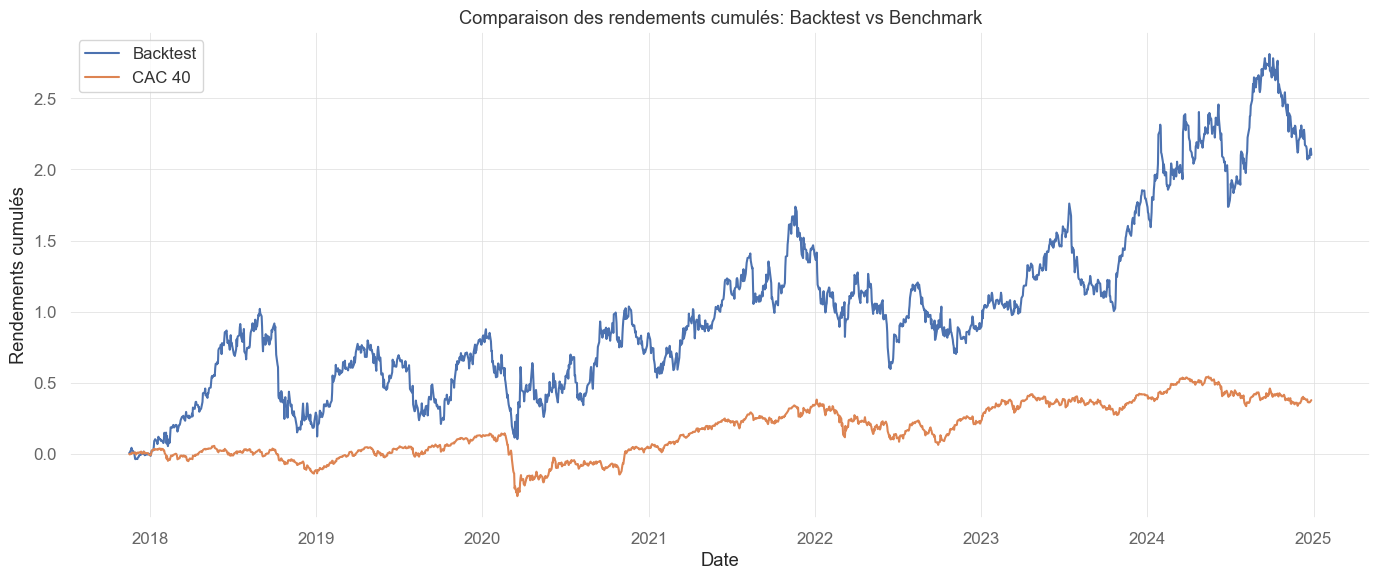

In [495]:
# Première date où les deux séries ont des données
date_debut_commune = max(backtest.dropna().index[0], cac40.dropna().index[0])

# Tronquage des séries pour qu'elles commencent à la date de début commune
backtest_tronqué = backtest[backtest.index >= date_debut_commune]
cac40_tronqué = cac40[cac40.index >= date_debut_commune]

# Conversion des rendements quotidiens en rendements cumulatifs à partir de la date de début commune
cumulative_rendements_backtest_tronqué = (1 + backtest_tronqué).cumprod() - 1
cumulative_rendements_cac40_tronqué = (1 + cac40_tronqué.pct_change().fillna(0)).cumprod() - 1


plt.figure(figsize=(14, 6))
plt.plot(cumulative_rendements_backtest_tronqué, label='Backtest')
plt.plot(cumulative_rendements_cac40_tronqué, label='CAC 40')
plt.title('Comparaison des rendements cumulés: Backtest vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Rendements cumulés')
plt.tight_layout()

plt.legend()
plt.show()

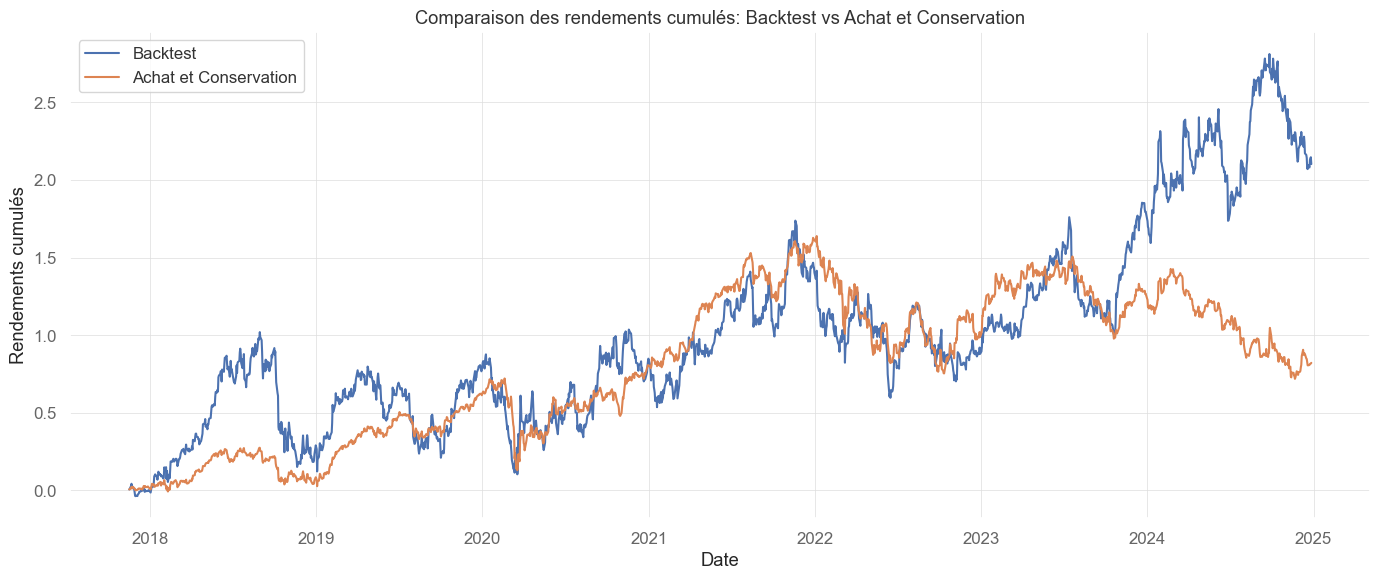

In [496]:
date_debut_commune = max(backtest.dropna().index[0], achat_conservation.dropna().index[0])

backtest_tronqué = backtest[backtest.index >= date_debut_commune]
achat_conservation_tronqué = achat_conservation[achat_conservation.index >= date_debut_commune]

cumulative_rendements_backtest = (1 + backtest_tronqué).cumprod() - 1
cumulative_rendements_achat_conservation = (1 + achat_conservation_tronqué).cumprod() - 1


plt.figure(figsize=(14, 6))
plt.plot(cumulative_rendements_backtest, label='Backtest')
plt.plot(cumulative_rendements_achat_conservation, label='Achat et Conservation')
plt.title('Comparaison des rendements cumulés: Backtest vs Achat et Conservation')
plt.xlabel('Date')
plt.ylabel('Rendements cumulés')
plt.tight_layout()

plt.legend()
plt.show()

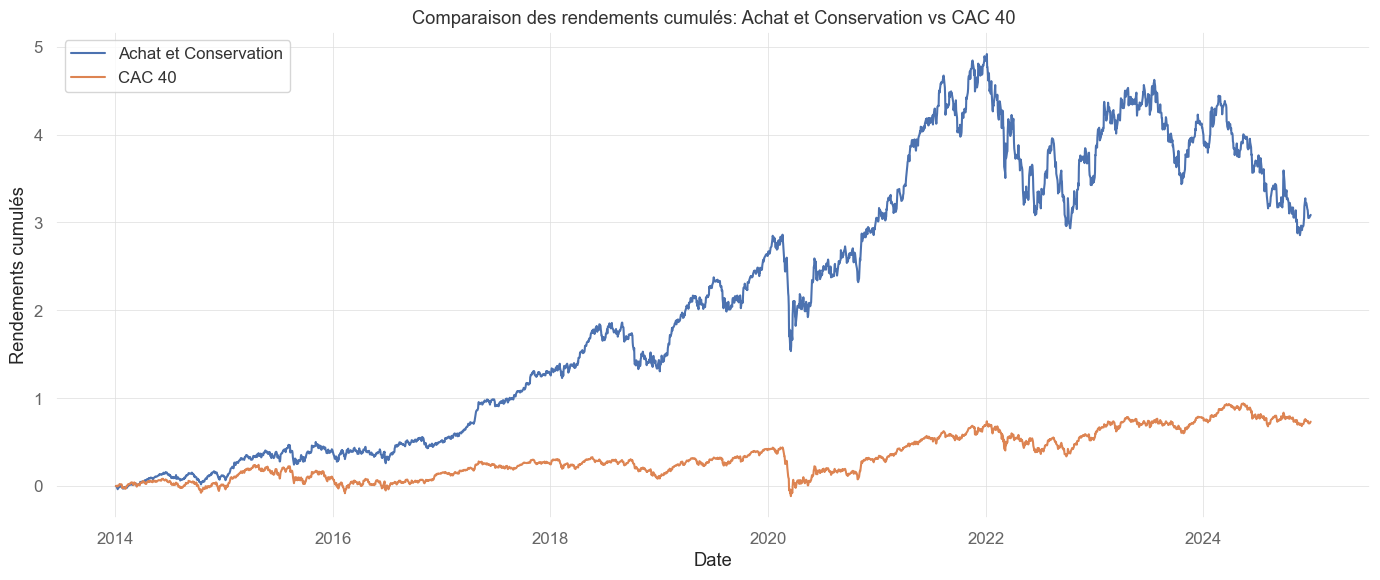

In [497]:
date_debut_commune = max(achat_conservation.dropna().index[0], cac40.dropna().index[0])

achat_conservation_tronqué = achat_conservation[achat_conservation.index >= date_debut_commune]
cac40_tronqué = cac40[cac40.index >= date_debut_commune]

# Calcul des rendements cumulés pour chaque série
cumulative_rendements_achat_conservation = (1 + achat_conservation_tronqué).cumprod() - 1
cumulative_rendements_cac40 = (1 + cac40_tronqué.pct_change().fillna(0)).cumprod() - 1

plt.figure(figsize=(14, 6))
plt.plot(cumulative_rendements_achat_conservation, label='Achat et Conservation')
plt.plot(cumulative_rendements_cac40, label='CAC 40')
plt.title('Comparaison des rendements cumulés: Achat et Conservation vs CAC 40')
plt.xlabel('Date')
plt.ylabel('Rendements cumulés')
plt.tight_layout()

plt.legend()
plt.show()